
===== TASK A: CLASSIFICATION — Bank Marketing =====
Shape: (45211, 16)
y
no     39922
yes     5289
Name: count, dtype: int64

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y        

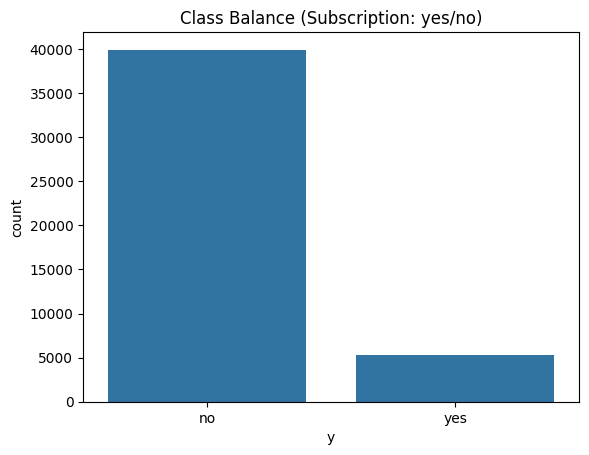

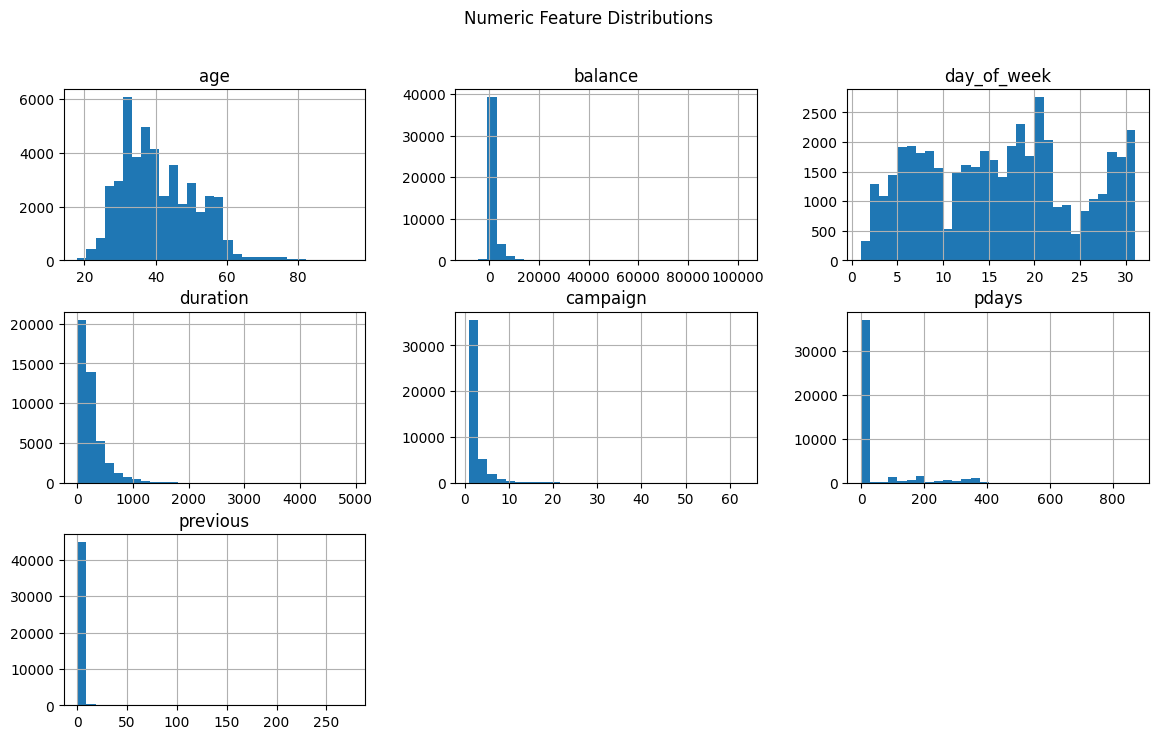

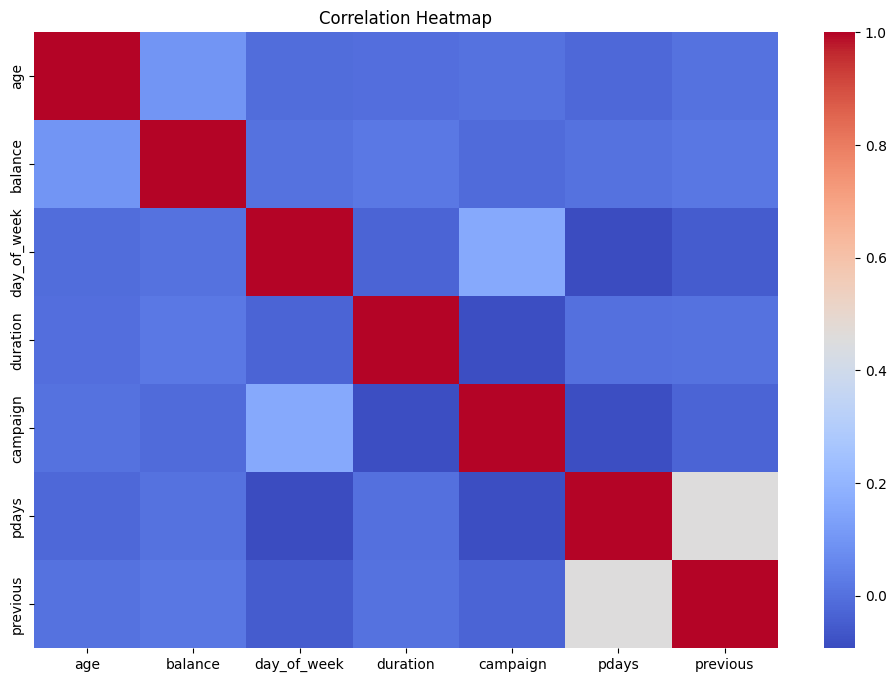

After SMOTE: [31937 31937]

--- LogisticRegression ---
ROC-AUC: 0.9079 | PR-AUC: 0.5366
F1: 0.5527 | Precision: 0.4182 | Recall: 0.8147
Confusion Matrix:
 [[6786 1199]
 [ 196  862]]

--- RandomForest ---
ROC-AUC: 0.9282 | PR-AUC: 0.6037
F1: 0.5782 | Precision: 0.5886 | Recall: 0.5681
Confusion Matrix:
 [[7565  420]
 [ 457  601]]

--- XGBoost ---
ROC-AUC: 0.9301 | PR-AUC: 0.6119
F1: 0.5913 | Precision: 0.6101 | Recall: 0.5737
Confusion Matrix:
 [[7597  388]
 [ 451  607]]


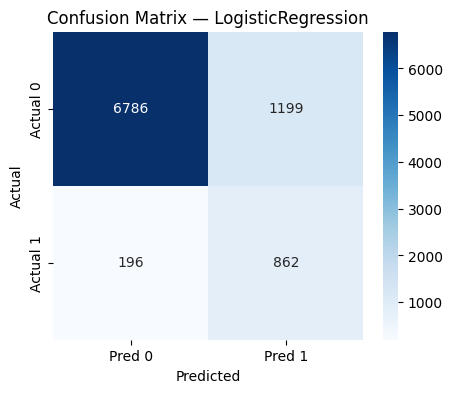

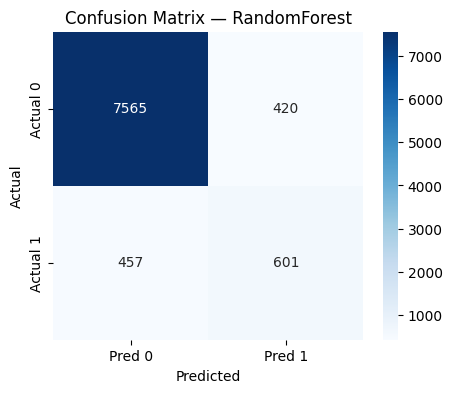

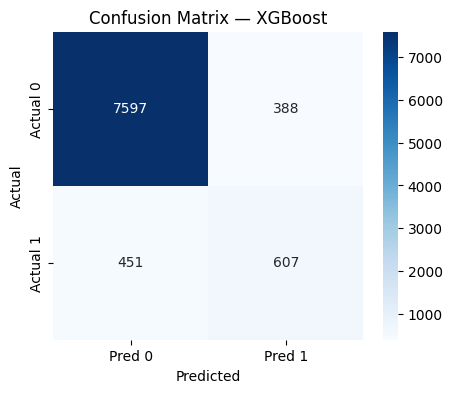


===== TASK B: CLUSTERING — Wholesale Customers =====
Shape: (440, 7)
   Channel  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2  12669  9656     7561     214              2674        1338
1        2   7057  9810     9568    1762              3293        1776
2        2   6353  8808     7684    2405              3516        7844
3        1  13265  1196     4221    6404               507        1788
4        2  22615  5410     7198    3915              1777        5185

Descriptive Statistics:
                  count          mean           std   min      25%     50%  \
Channel           440.0      1.322727      0.468052   1.0     1.00     1.0   
Fresh             440.0  12000.297727  12647.328865   3.0  3127.75  8504.0   
Milk              440.0   5796.265909   7380.377175  55.0  1533.00  3627.0   
Grocery           440.0   7951.277273   9503.162829   3.0  2153.00  4755.5   
Frozen            440.0   3071.931818   4854.673333  25.0   742.25  1526.0   
Detergents_

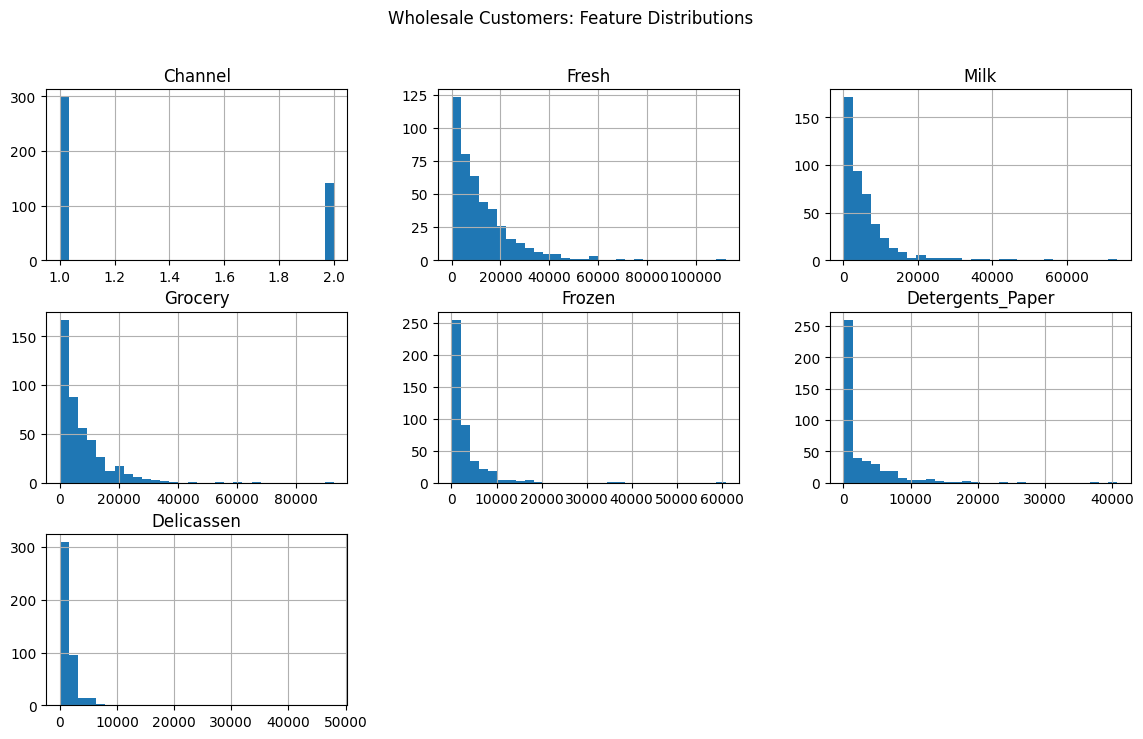

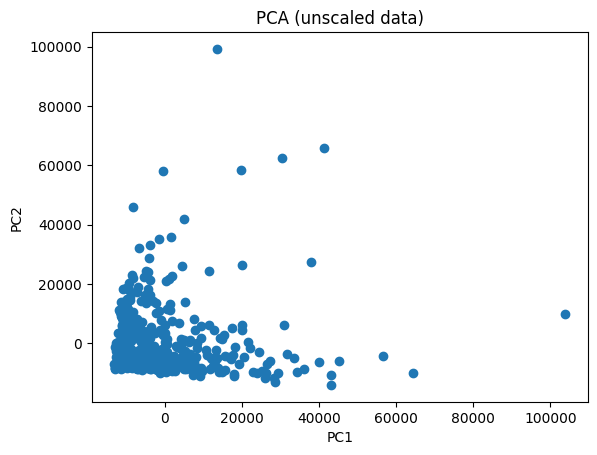

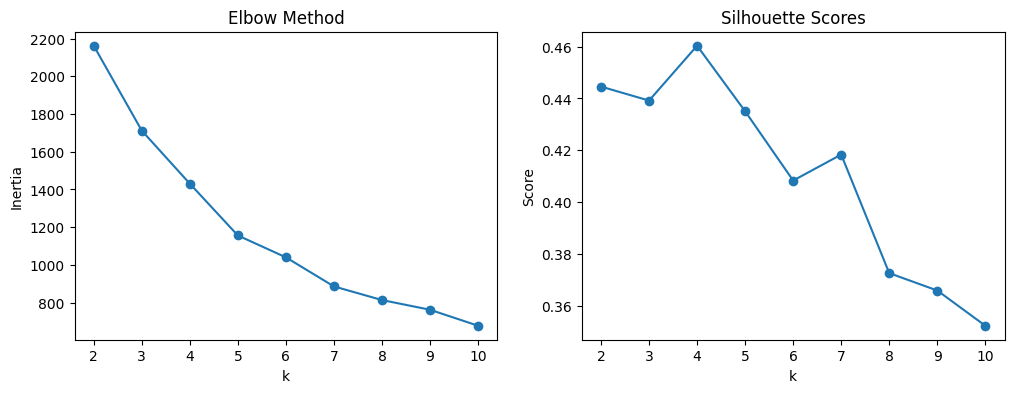

KMeans Silhouette: 0.43916005773275374
Agglomerative Silhouette: 0.407084011561323


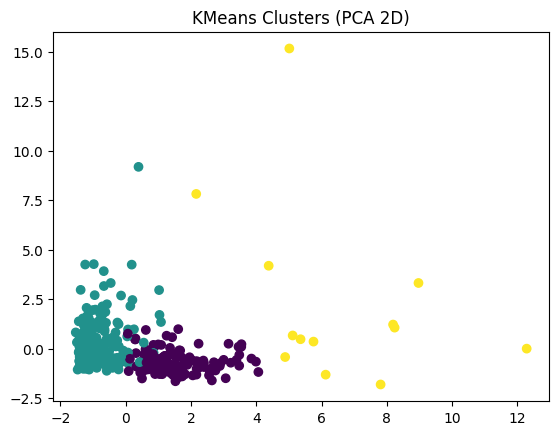


Cluster Profiles:
          Channel         Fresh          Milk       Grocery       Frozen  \
Cluster                                                                    
0        2.000000   8165.915385   8748.515385  13905.492308  1441.630769   
1        1.003367  13075.898990   3218.737374   3855.696970  3620.400673   
2        1.846154  25770.769231  35160.384615  41977.384615  6844.538462   

         Detergents_Paper   Delicassen  
Cluster                                 
0             5991.146154  1535.007692  
1              776.875421  1242.249158  
2            19867.384615  7880.307692  


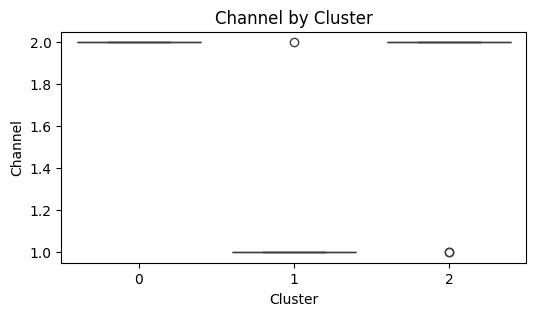

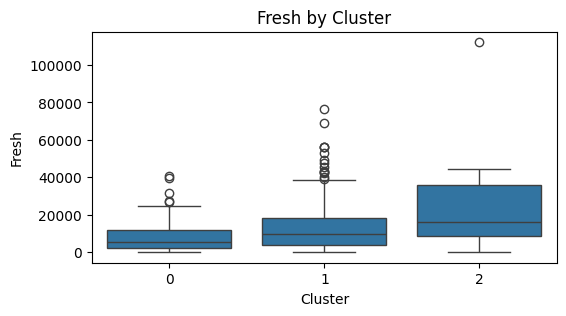

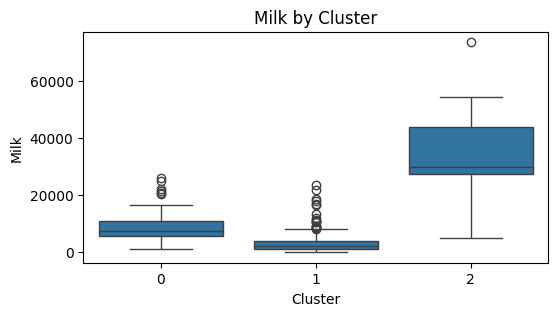

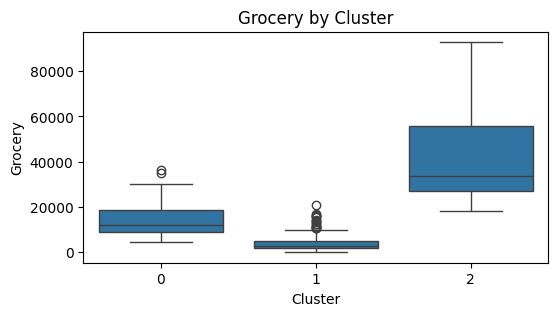

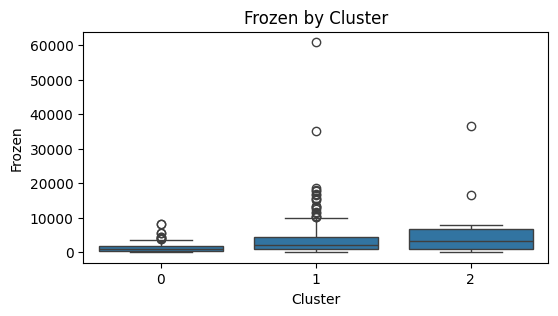

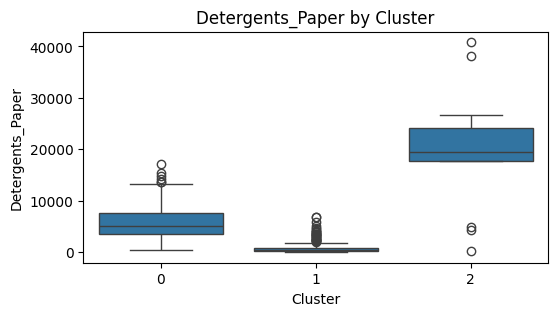

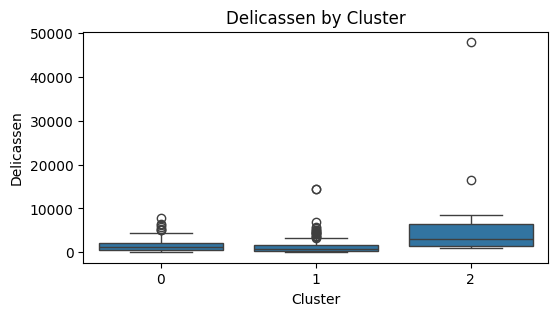


✅ Done! Both tasks completed successfully.


In [ ]:
# ==============================================
# 📘 SIS-3: Practical ML Assignment (Fall 2025)
# ==============================================
# One notebook for both tasks: Classification & Clustering
# ==============================================


# ==============================================
# 🔹 IMPORTS AND SETUP
# ==============================================
import pandas as pd
import numpy as np # work with data 
import matplotlib.pyplot as plt
import seaborn as sns # work with visualization
# sklearn for teaching models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    f1_score, precision_score, recall_score, confusion_matrix
)
from imblearn.over_sampling import SMOTE # class balance (artifical record of generated data)
from xgboost import XGBClassifier # ml model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

from ucimlrepo import fetch_ucirepo


# ==============================================
# 🔹 TASK A — CLASSIFICATION (Bank Marketing)
# ==============================================

print("\n===== TASK A: CLASSIFICATION — Bank Marketing =====")

# --- Load dataset ---
bank = fetch_ucirepo(id=222) # Bank Marketing repo import -> predicting of whether a person will purchase deposit(yes/no)
X_bank = bank.data.features # age, work, grade
y_bank = bank.data.targets.iloc[:, 0]  # yes/no
y_bank.name = 'y'                  


print("Shape:", X_bank.shape) # yes -> few, no -> a lot 
# num_features = X_bank.shape[1]
print(y_bank.value_counts())

# --- Combine for EDA ---
df_bank = pd.concat([X_bank, y_bank], axis=1) # features + target

# --- EDA ---
print("\nBasic Info:")
print(df_bank.info()) # data types, maybe outliers
print("\nMissing values:\n", df_bank.isna().sum().sum()) # checking for outliers

# Visualize class balance
sns.countplot(x='y', data=df_bank) # checking balance of classes(skew/imbalance)
plt.title("Class Balance (Subscription: yes/no)")
plt.show()

# Numerical distributions
num_cols = df_bank.select_dtypes(include=['int64', 'float64']).columns
df_bank[num_cols].hist(bins=30, figsize=(14,8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_bank[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


# --- Preprocessing ---
X = X_bank.copy()
y = (y_bank == 'yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_features = X.select_dtypes(include=['int64','float64']).columns # numerical features
cat_features = X.select_dtypes(include=['object','category']).columns # categorical features

numeric_transformer = Pipeline([('scaler', StandardScaler())]) # 0 or 1(average or deviation) -> urgent for SVM, KNN, PCA & Logistic Regression
cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # for preparing categorical data to int -> for ml working
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# --- Preprocess data FIRST ---
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# --- Handle imbalance with SMOTE (after preprocessing) ---(for balancing 50/50 for better Recall and F1)
# both of Recall & F1 - purposed to accuracy of positive result
# Random Forest - generates parallel models
# XGBoost - models generates by sequently , correcting previous by gradient
# ROC - Receiver Operating Curve
# AUC - Area Under Curve -> false pos by X & true pos by Y -> balanced data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_preprocessed, y_train)
print("After SMOTE:", np.bincount(y_train_sm))


# --- Models ---
# Now we don't need preprocessing in pipeline since data is already preprocessed
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models
lr.fit(X_train_preprocessed, y_train)
rf.fit(X_train_sm, y_train_sm)
xgb.fit(X_train_sm, y_train_sm)


# --- Evaluation ---
models = {'LogisticRegression': lr, 'RandomForest': rf, 'XGBoost': xgb}

for name, model in models.items():
    y_prob = model.predict_prob(X_test_preprocessed)[:,1]
    y_pred = model.predict(X_test_preprocessed)
    
    roc = roc_auc_score(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(rec, prec)
    
    f1 = f1_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n--- {name} ---")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"F1: {f1:.4f} | Precision: {p:.4f} | Recall: {r:.4f}")
    print("Confusion Matrix:\n", cm)
    

# Confusion Matrix
for name, model in models.items():
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Actual 0", "Actual 1"]
    )
    
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



# ==============================================
# 🔹 TASK B — CLUSTERING (Wholesale Customers)
# ==============================================

print("\n===== TASK B: CLUSTERING — Wholesale Customers =====")

# --- Load dataset ---
wholesale = fetch_ucirepo(id=292)
X_wh = wholesale.data.features
print("Shape:", X_wh.shape)
print(X_wh.head())

# --- EDA ---
print("\nDescriptive Statistics:")
print(X_wh.describe().T)

X_wh.hist(bins=30, figsize=(14,8))
plt.suptitle("Wholesale Customers: Feature Distributions")
plt.show()

# --- PCA Visualization (before scaling) ---
pca_raw = PCA(n_components=2)
pca_raw_2d = pca_raw.fit_transform(X_wh)
plt.scatter(pca_raw_2d[:,0], pca_raw_2d[:,1])
plt.title("PCA (unscaled data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# --- Preprocessing ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wh)

# --- Elbow + Silhouette ---
inertia, sil = [], []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))
# K - center - positioning points by nearest center
# Agglomerative - hierarchical, more stable compared KMeans

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, '-o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, sil, '-o')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

best_k = 3  # adjust after checking graph

# --- KMeans ---
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
print("KMeans Silhouette:", silhouette_score(X_scaled, labels_km))

# --- Agglomerative ---
agg = AgglomerativeClustering(n_clusters=best_k)
labels_ag = agg.fit_predict(X_scaled)
print("Agglomerative Silhouette:", silhouette_score(X_scaled, labels_ag))


# --- PCA visualization ---
pca2 = PCA(n_components=2)
pcs2 = pca2.fit_transform(X_scaled)
plt.scatter(pcs2[:,0], pcs2[:,1], c=labels_km, cmap='viridis')
plt.title("KMeans Clusters (PCA 2D)")
plt.show()

# --- Cluster profiles ---
df_scaled = pd.DataFrame(X_wh, columns=X_wh.columns)
df_scaled['Cluster'] = labels_km
cluster_profiles = df_scaled.groupby('Cluster').mean()
print("\nCluster Profiles:")
print(cluster_profiles)

# --- Boxplots by cluster ---
for col in X_wh.columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Cluster', y=col, data=df_scaled)
    plt.title(f"{col} by Cluster")
    plt.show()

print("\n✅ Done! Both tasks completed successfully.")